In [1]:
from IPython.display import clear_output
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)
sns.set_palette(sns.color_palette("Set2"))
print(f"Running on {sys.version}")

Running on 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")
df_og = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
df_train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [3]:
df_og

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [4]:
df_train = pd.concat([df_train, df_og], axis = 0, ignore_index = True)
df_train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,RowNumber
0,0.0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,NaN
1,1.0,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,NaN
2,2.0,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,NaN
3,3.0,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,NaN
4,4.0,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175031,NaN,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,9998.0
175032,NaN,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,9999.0
175033,NaN,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,9999.0
175034,NaN,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,10000.0


In [5]:
df_train = df_train.drop(["id", "RowNumber"], axis = 1)
df_test = df_test.drop(["id"], axis = 1)
df_test

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...
110018,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [6]:
df_train['Exited'].value_counts()

Exited
0    138077
1     36959
Name: count, dtype: int64

In [7]:
df_train.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
df_train = df_train.drop(["Surname"], axis = 1)
df_test = df_test.drop(["Surname"], axis = 1)
df_train

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
175031,15584532,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
175032,15682355,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
175033,15682355,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
175034,15628319,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 65.6 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)


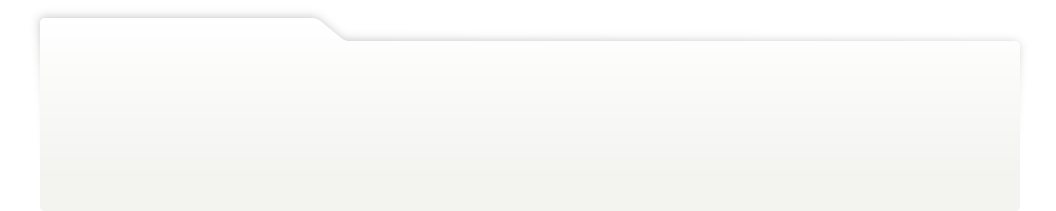
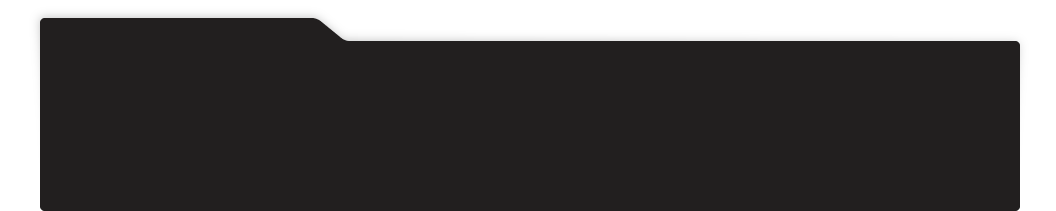
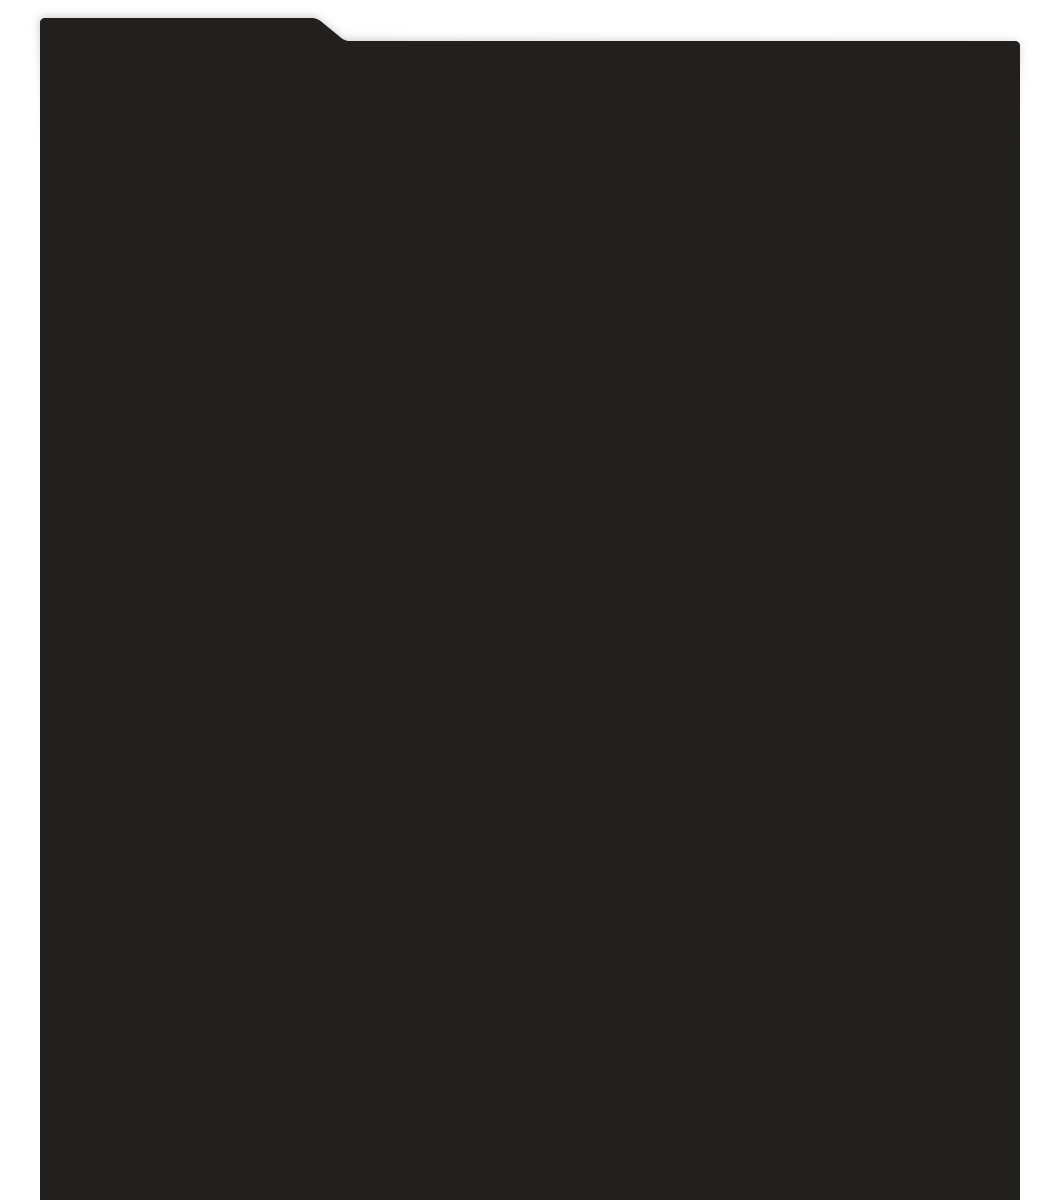
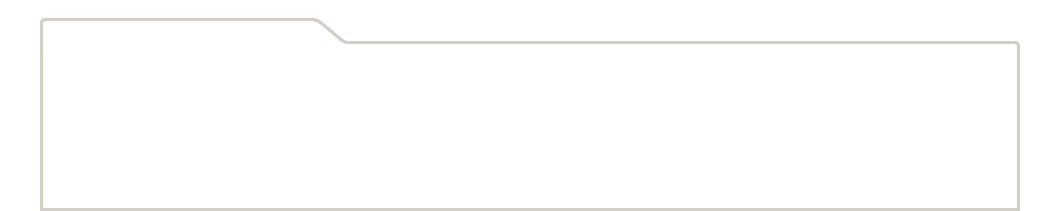
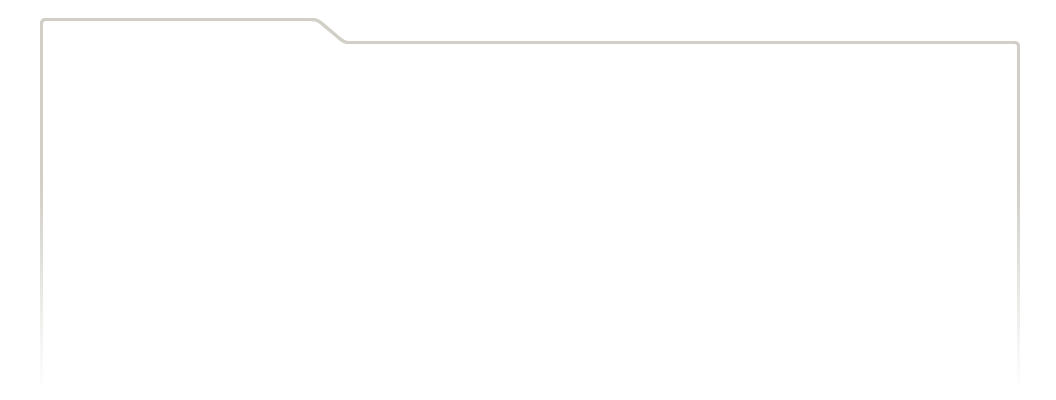
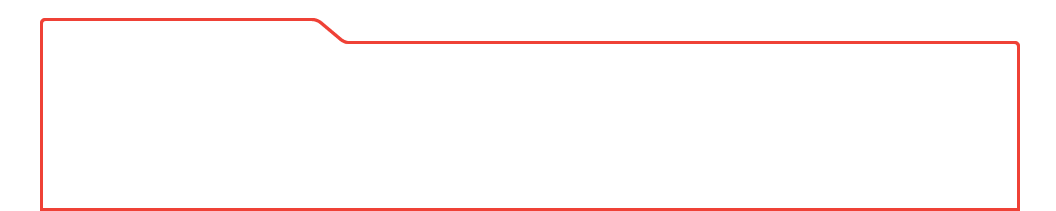
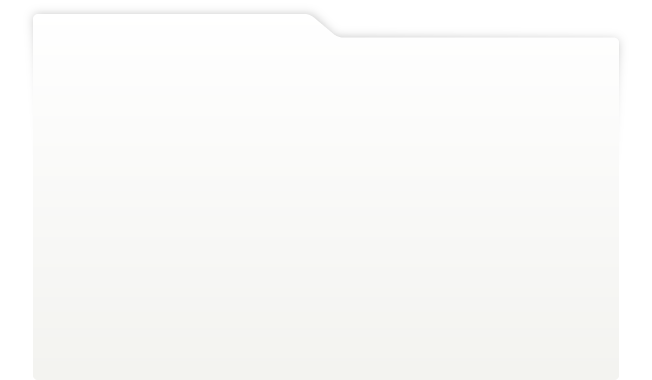
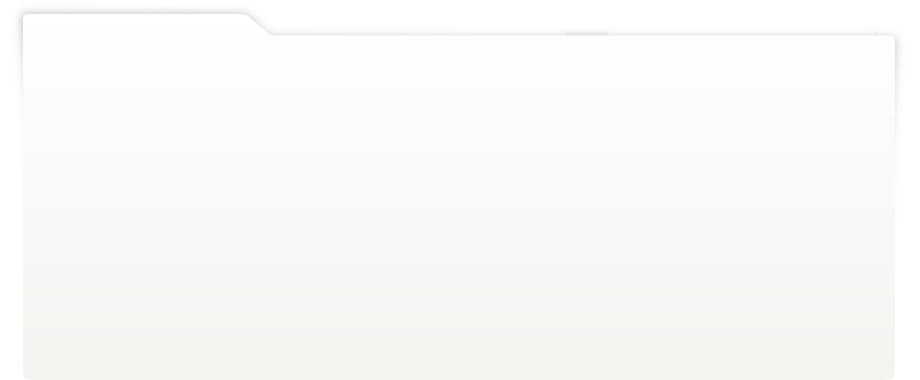
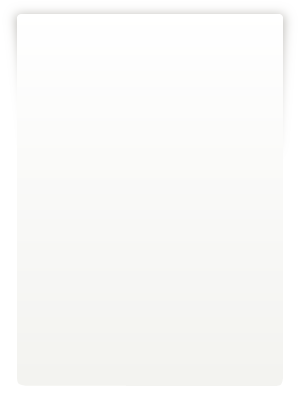
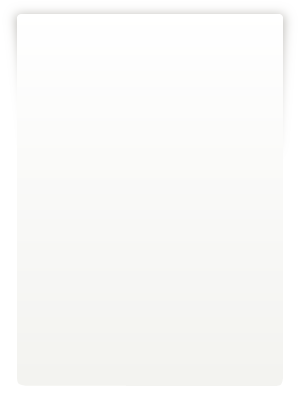
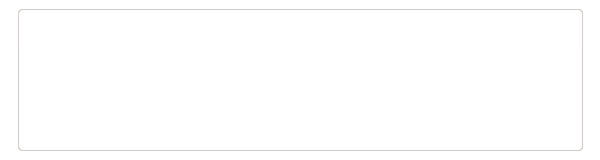
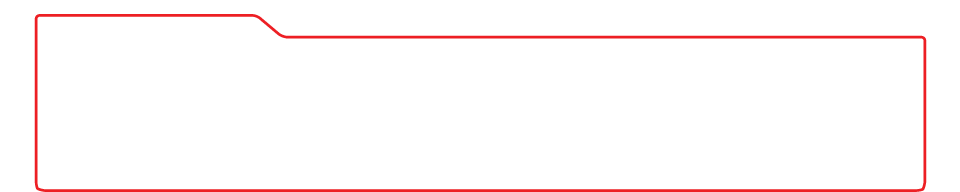
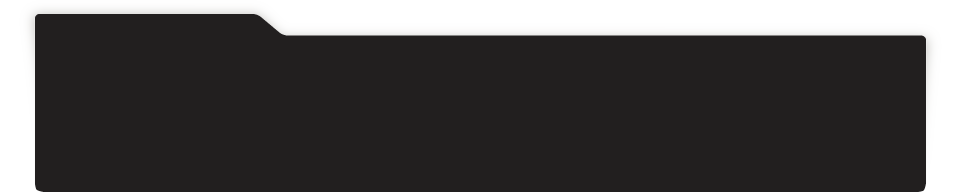
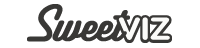
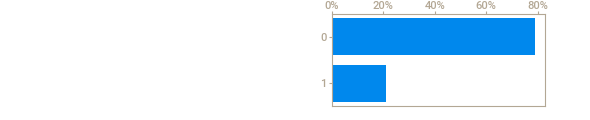
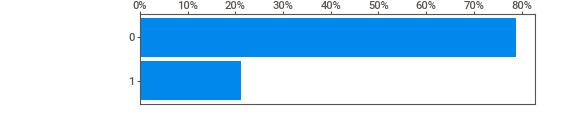
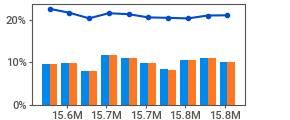
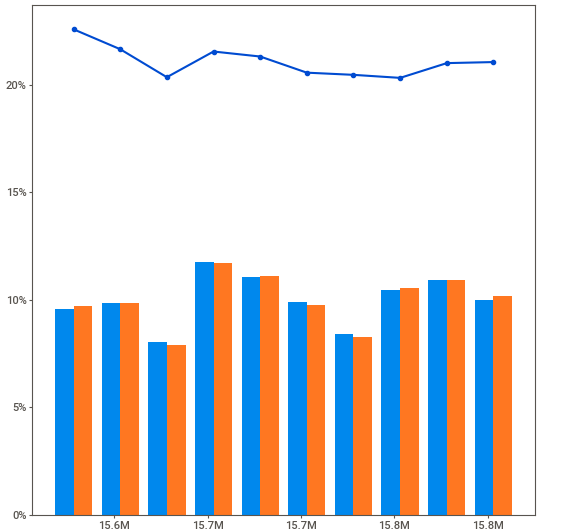
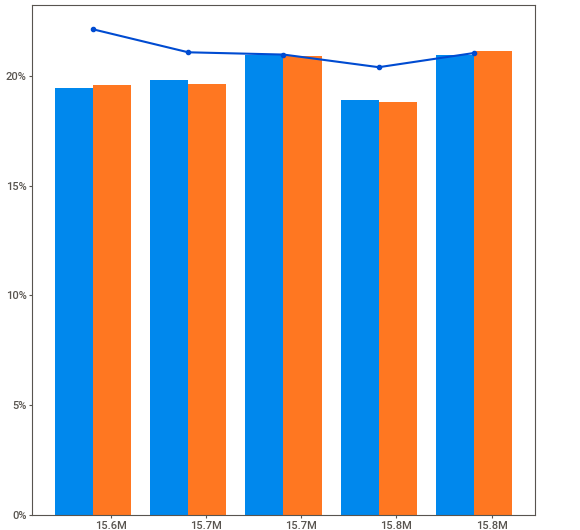
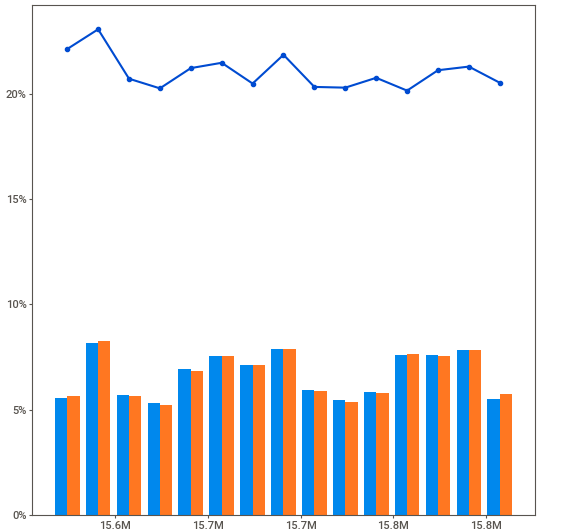
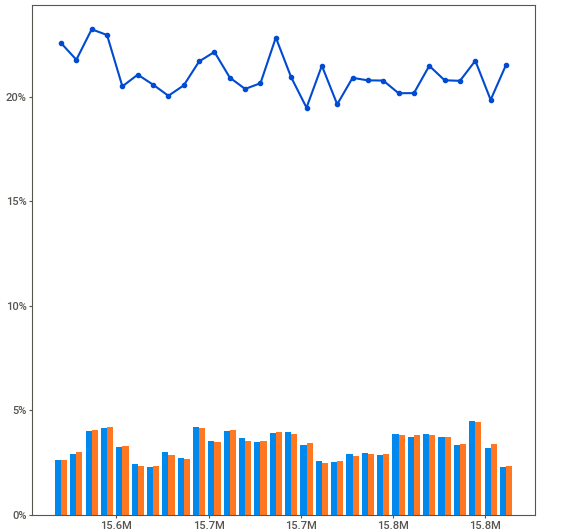
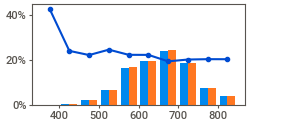
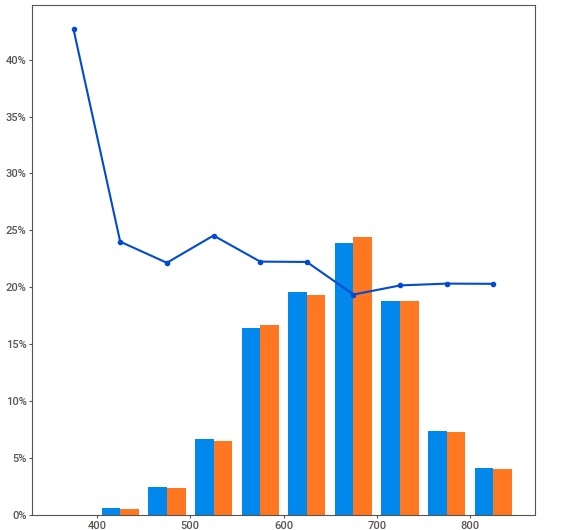
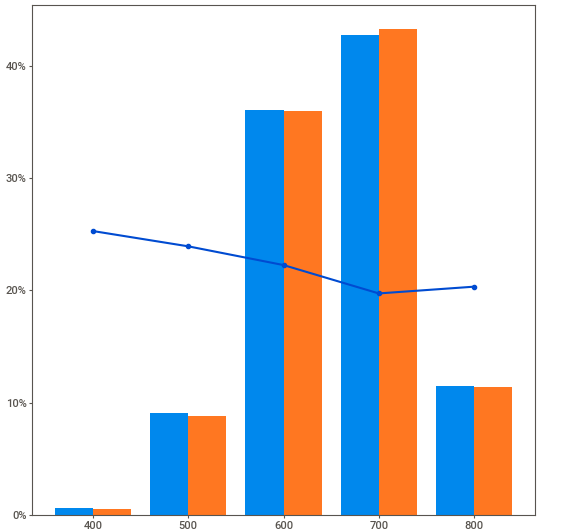
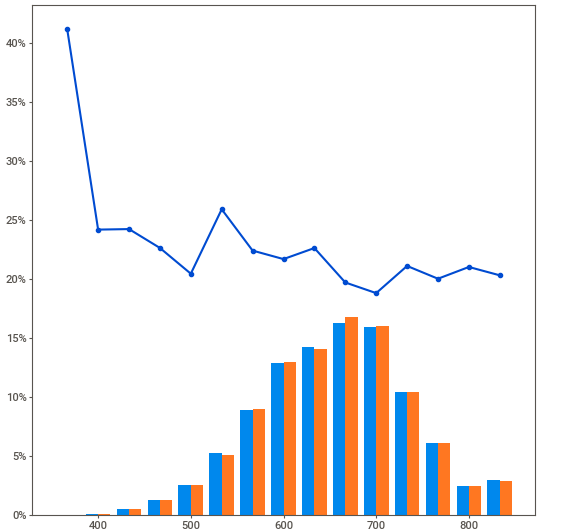
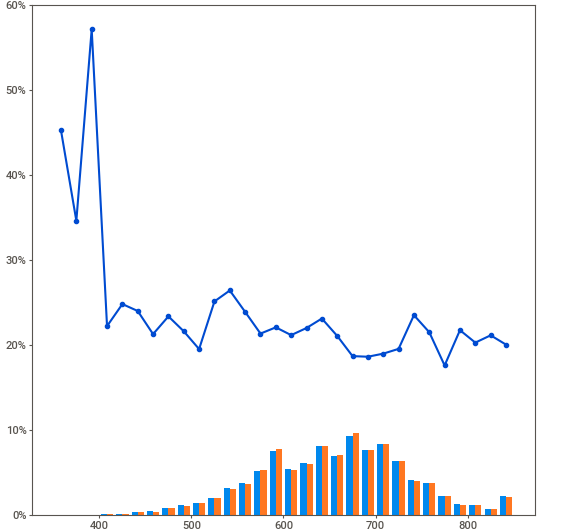
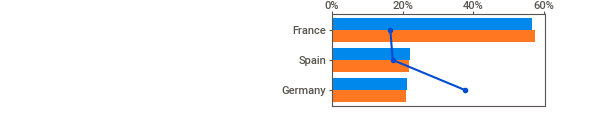
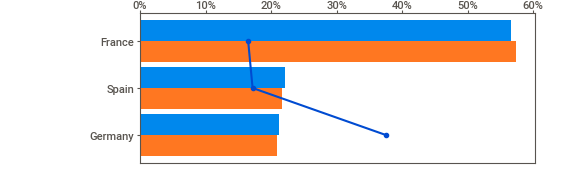
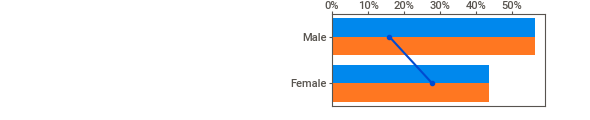
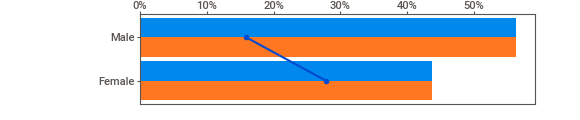
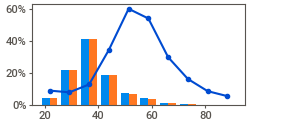
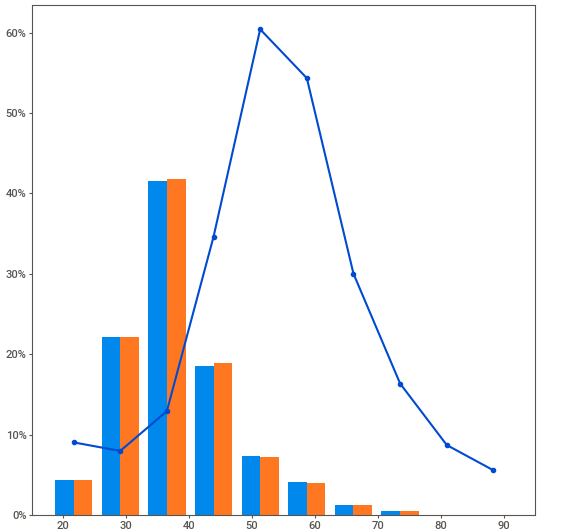
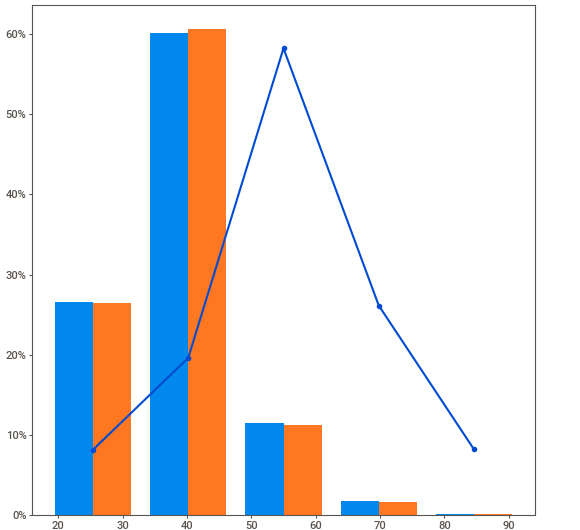
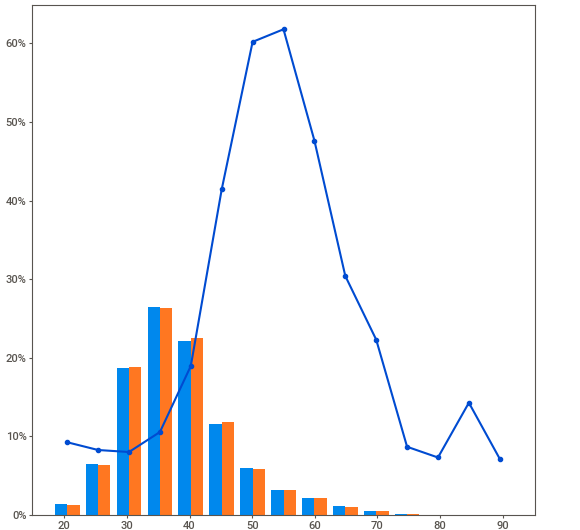
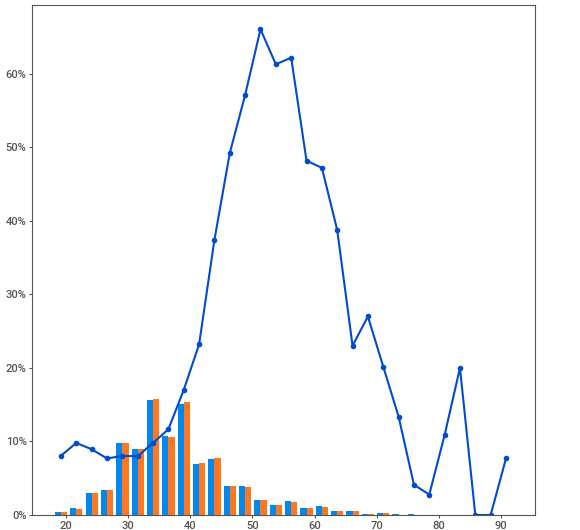
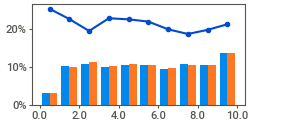
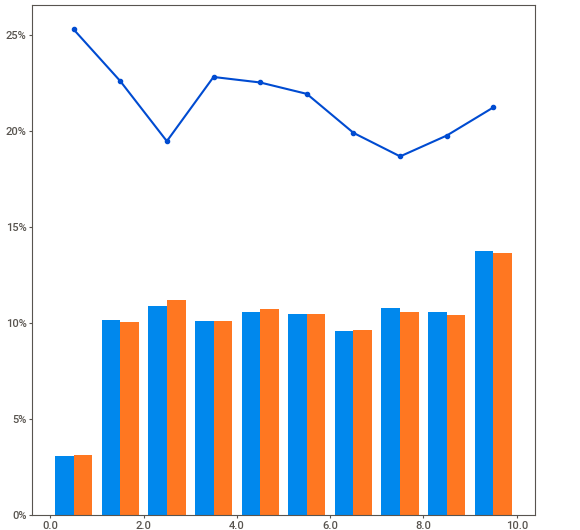
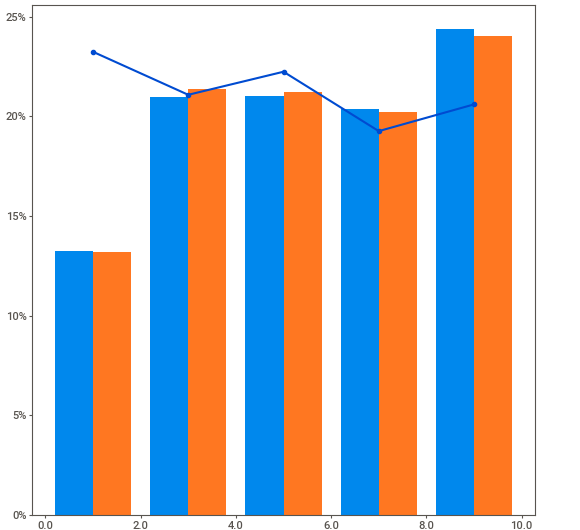
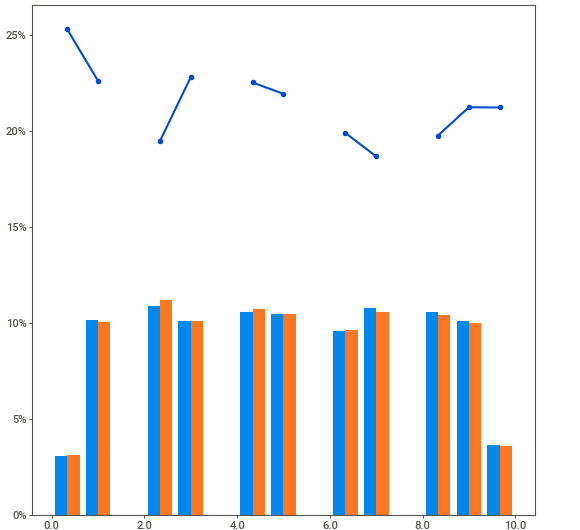
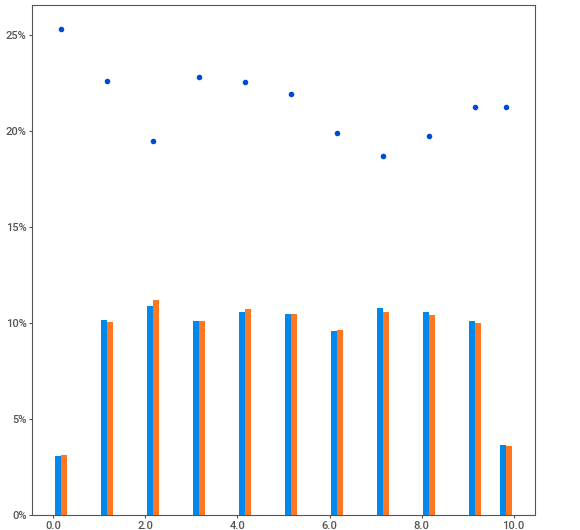
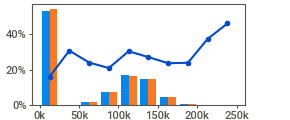
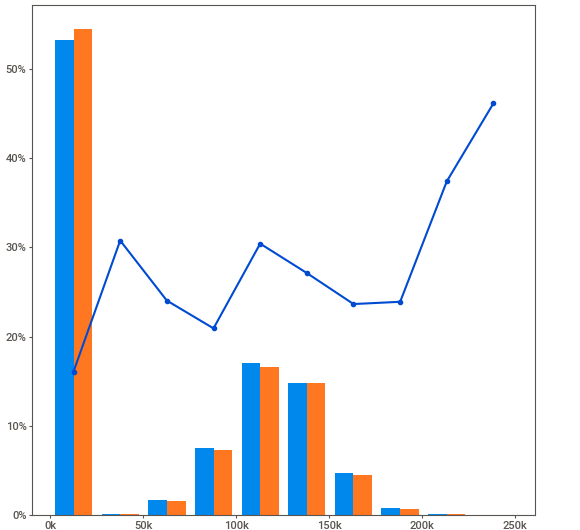
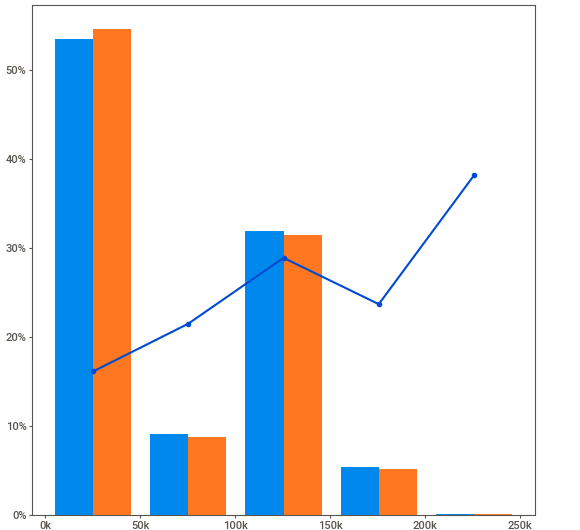
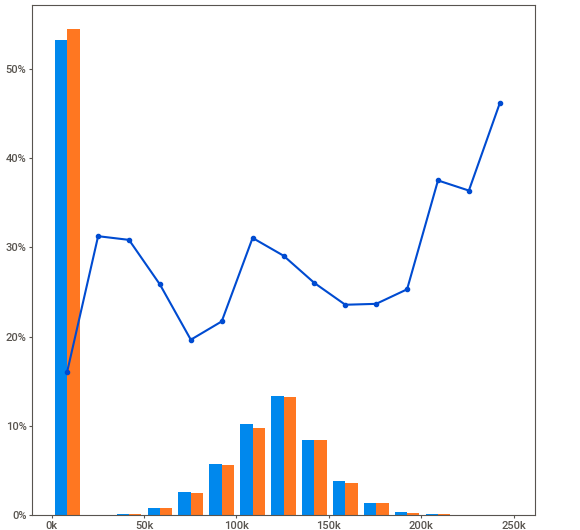
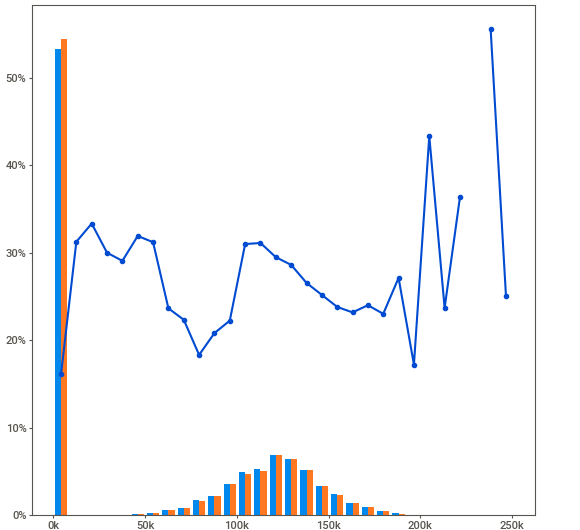
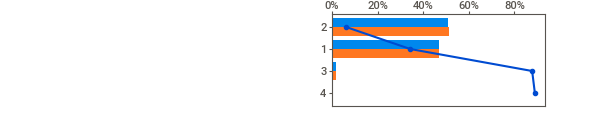
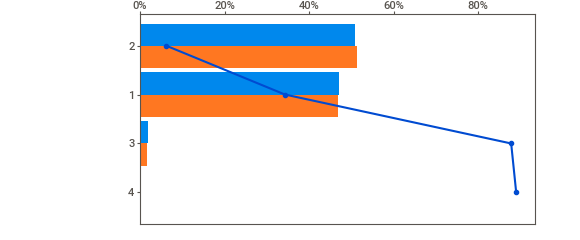
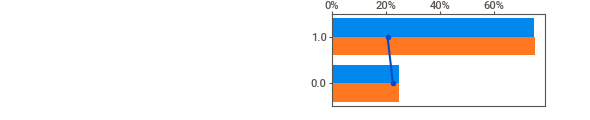
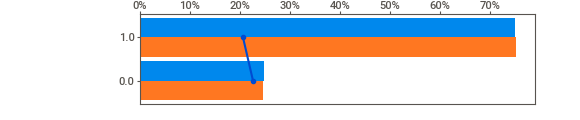
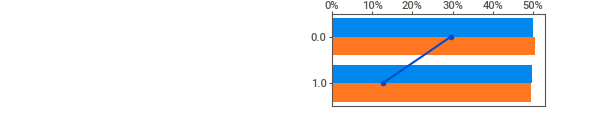
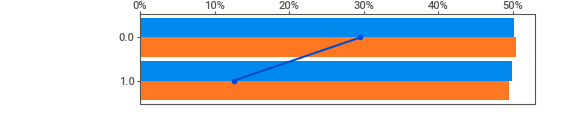
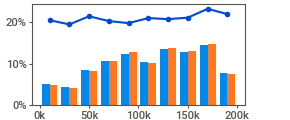
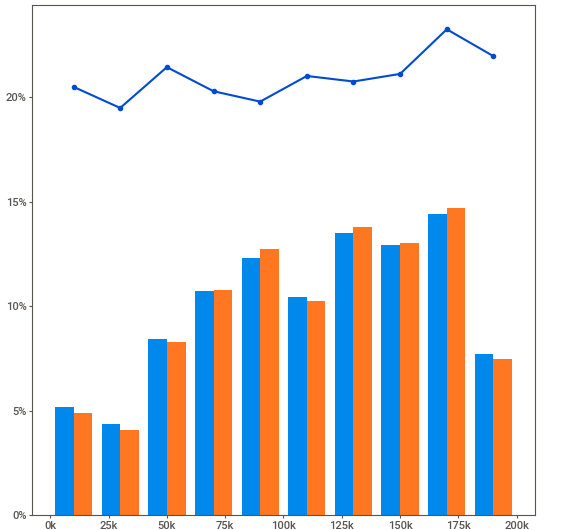
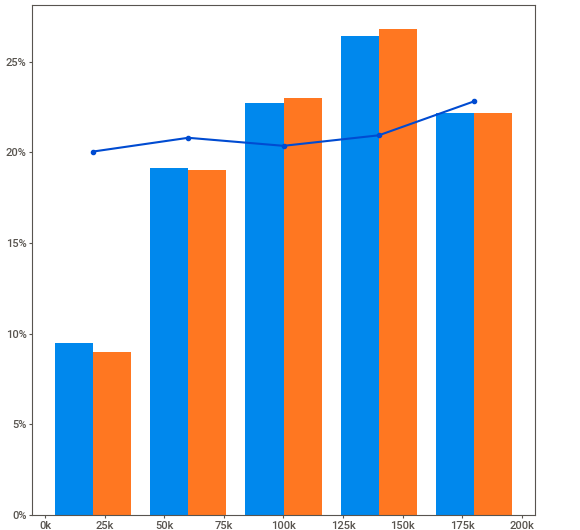
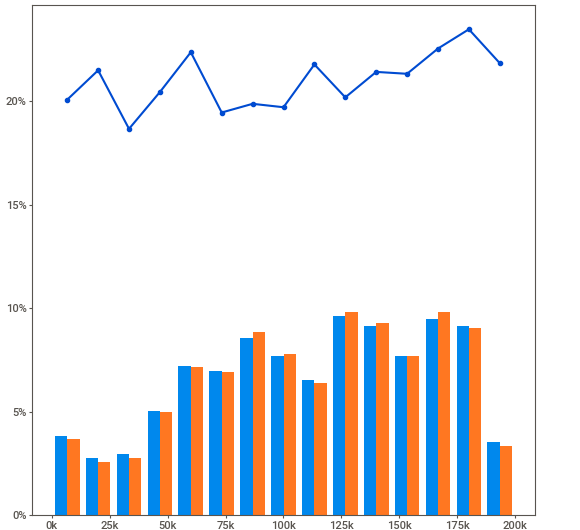
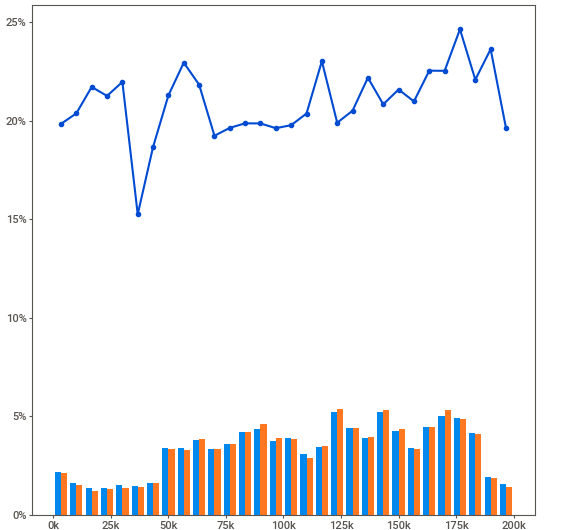
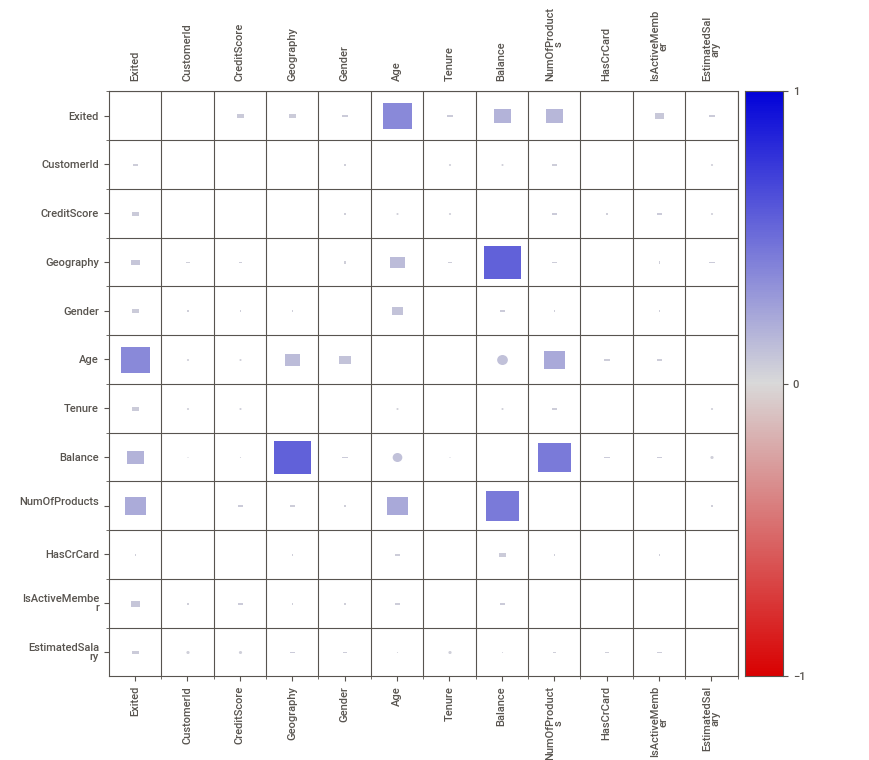
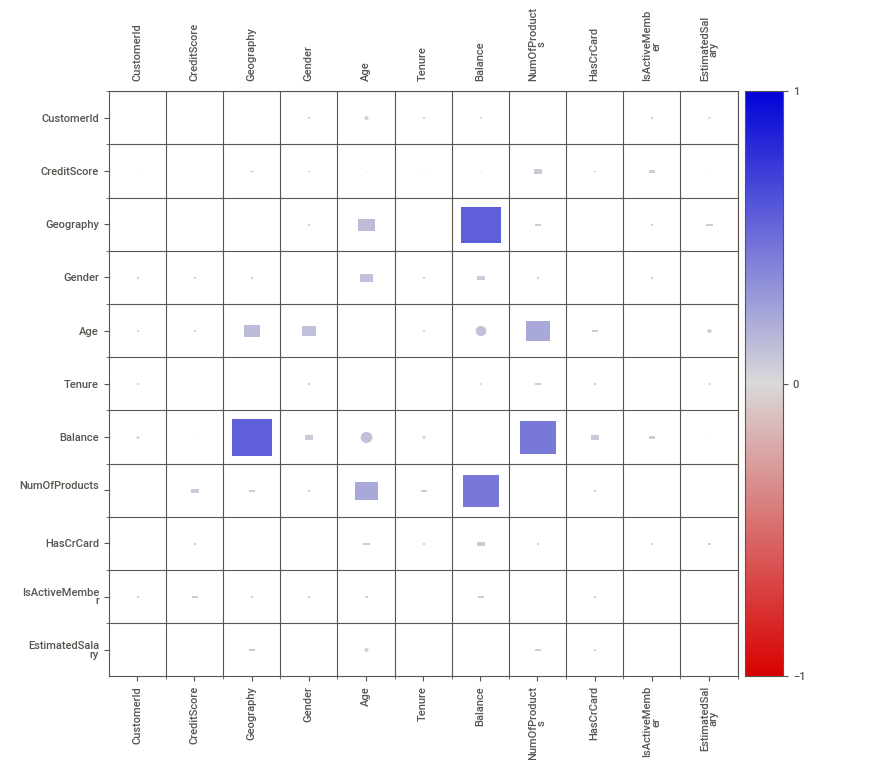

In [9]:
!pip install sweetviz

import sweetviz 

comparision_report = sweetviz.compare([df_train, "Train"], [df_test, "Test"], "Exited")
comparision_report.show_notebook(w="100%", h="Full")

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

# n_folds = 5
# repeats = 3

In [11]:
from sklearn.preprocessing import LabelEncoder

object_train_columns = df_train.select_dtypes(include=['object']).columns
object_test_columns = df_test.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for col in object_train_columns:
    df_train[col] = label_encoder.fit_transform(df_train[col])

for col1 in object_test_columns:
    df_test[col1] = label_encoder.fit_transform(df_test[col1])
    
df_train

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
175031,15584532,709,0,0,36.0,7,0.00,1,0.0,1.0,42085.58,1
175032,15682355,772,1,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1
175033,15682355,772,1,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1
175034,15628319,792,0,0,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [12]:
df_train.sort_values(["Age"], ascending = True)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
49886,15634146,835,1,1,18.0,4,142872.36,1,1.0,1.0,117632.63,0
161225,15750929,702,2,1,18.0,8,0.00,2,1.0,0.0,99654.13,0
12069,15757897,771,0,1,18.0,1,0.00,1,1.0,1.0,41542.95,0
112022,15673180,745,1,1,18.0,4,104702.65,2,1.0,0.0,107948.72,0
27695,15676526,648,0,0,18.0,4,137964.51,1,1.0,0.0,167032.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59479,15691624,820,0,1,92.0,0,0.00,2,1.0,1.0,23067.97,0
163138,15721917,684,0,0,92.0,3,95139.41,1,1.0,1.0,86575.46,0
116359,15655961,790,0,1,92.0,1,0.00,2,0.0,1.0,93302.29,0
164009,15586523,705,0,0,92.0,1,126076.24,1,1.0,1.0,34436.83,0


In [13]:
X = df_train.drop(["Exited"], axis = 1)
y = df_train["Exited"]

In [14]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

class SalaryAndTenure(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['SalaryAndTenure'] = X['Tenure'] * X['EstimatedSalary']
        return X
    
# class AgeYearsTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         X['Age_Years'].fillna(-1, inplace=True)
#         X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
#         return X

# class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         X['Age_Years'].fillna(-1, inplace=True)  # Fill NaN values with a placeholder
#         X['Age_Group'] = pd.cut(X['Age_Years'], bins=[17, 24, 49, 64, 92], labels=[0, 1, 2, 3]).astype('int16')
#         return X

class CreditScoreAgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['CreditScoreAgeTransformer'] = X['CreditScore'] * X['Age']
        return X

class CreditScoreTenureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['CreditScoreTenureTransformer'] = X['CreditScore'] * X['Tenure']
        return X
    
class SalaryProductsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['SalaryProductsTransformer'] = X['EstimatedSalary'] / X['NumOfProducts']
        return X

class MoneyMeanTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        mean_columns = ['CreditScore', 'Balance', "EstimatedSalary"]
        X['MoneyMeanTransformer'] = X[mean_columns].mean(axis=1)
        return X

class BalanceBySalaryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['BalanceBySalaryTransformer'] = X['Balance'] / X['EstimatedSalary']
        return X
    
class AgeTenureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['AgeTenureTransformer'] = X['Age'] - X['Tenure']
        return X
    
pipeline = Pipeline([
    ('SalaryAndTenure', SalaryAndTenure()),
#     ('age_years', AgeYearsTransformer()),
#     ('age_groups', AgeGroupsTransformer()),
    ('CreditScoreAndAge', CreditScoreAgeTransformer()),
    ('CreditScoreAndTenure', CreditScoreTenureTransformer()),
    ('SalaryAndProducts', SalaryProductsTransformer()),
    ('TotalMoneyMean', MoneyMeanTransformer()),
    ('BalanceBySalary', BalanceBySalaryTransformer()),
    ('AgeAndTenure', AgeTenureTransformer())
])

df_train = pipeline.fit_transform(df_train)
df_test = pipeline.transform(df_test)


In [15]:
df_train

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,SalaryAndTenure,CreditScoreAgeTransformer,CreditScoreTenureTransformer,SalaryProductsTransformer,MoneyMeanTransformer,BalanceBySalaryTransformer,AgeTenureTransformer
0,15674932,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,544349.91,22044.0,2004,90724.985,60705.990000,0.000000,30.0
1,15749177,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,49503.50,20691.0,627,24751.750,16710.166667,0.000000,32.0
2,15694510,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1848666.90,27120.0,6780,92433.345,61848.230000,0.000000,30.0
3,15741417,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,169121.76,19754.0,1162,84560.880,78008.140000,1.760655,32.0
4,15766172,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,75344.15,23628.0,3580,7534.415,5261.610000,0.000000,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175031,15584532,709,0,0,36.0,7,0.00,1,0.0,1.0,42085.58,1,294599.06,25524.0,4963,42085.580,14264.860000,0.000000,29.0
175032,15682355,772,1,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1,278665.56,32424.0,2316,46444.260,56245.276667,0.808230,39.0
175033,15682355,772,1,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1,278665.56,32424.0,2316,46444.260,56245.276667,0.808230,39.0
175034,15628319,792,0,0,28.0,4,130142.79,1,1.0,0.0,38190.78,0,152763.12,22176.0,3168,38190.780,56375.190000,3.407702,24.0


In [16]:
print(np.isnan(df_train).any())

CustomerId                      False
CreditScore                     False
Geography                       False
Gender                          False
Age                              True
Tenure                          False
Balance                         False
NumOfProducts                   False
HasCrCard                        True
IsActiveMember                   True
EstimatedSalary                 False
Exited                          False
SalaryAndTenure                 False
CreditScoreAgeTransformer        True
CreditScoreTenureTransformer    False
SalaryProductsTransformer       False
MoneyMeanTransformer            False
BalanceBySalaryTransformer      False
AgeTenureTransformer             True
dtype: bool


In [17]:
object_columns_train = df_train.select_dtypes(include=['object']).columns
df_train = pd.get_dummies(df_train, columns = object_columns_train, drop_first = True)

boolean_columns_train = df_train.select_dtypes(include=['bool']).columns
df_train[boolean_columns_train] = df_train[boolean_columns_train].astype(int)


object_columns_test = df_test.select_dtypes(include=['object']).columns
df_test = pd.get_dummies(df_test, columns=object_columns_test, drop_first=True)

boolean_columns_test = df_test.select_dtypes(include=['bool']).columns
df_test[boolean_columns_test] = df_test[boolean_columns_test].astype(int)

In [18]:
missing = [f for f in df_train.columns if df_train[f].dtype!="O" and df_train[f].isna().sum()>0]
for f in missing:
    df_train[f]=df_train[f].fillna(df_train[f].mean())
print(np.isnan(df_train).any())

CustomerId                      False
CreditScore                     False
Geography                       False
Gender                          False
Age                             False
Tenure                          False
Balance                         False
NumOfProducts                   False
HasCrCard                       False
IsActiveMember                  False
EstimatedSalary                 False
Exited                          False
SalaryAndTenure                 False
CreditScoreAgeTransformer       False
CreditScoreTenureTransformer    False
SalaryProductsTransformer       False
MoneyMeanTransformer            False
BalanceBySalaryTransformer      False
AgeTenureTransformer            False
dtype: bool


In [19]:
df_train

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,SalaryAndTenure,CreditScoreAgeTransformer,CreditScoreTenureTransformer,SalaryProductsTransformer,MoneyMeanTransformer,BalanceBySalaryTransformer,AgeTenureTransformer
0,15674932,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,544349.91,22044.0,2004,90724.985,60705.990000,0.000000,30.0
1,15749177,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,49503.50,20691.0,627,24751.750,16710.166667,0.000000,32.0
2,15694510,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1848666.90,27120.0,6780,92433.345,61848.230000,0.000000,30.0
3,15741417,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,169121.76,19754.0,1162,84560.880,78008.140000,1.760655,32.0
4,15766172,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,75344.15,23628.0,3580,7534.415,5261.610000,0.000000,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175031,15584532,709,0,0,36.0,7,0.00,1,0.0,1.0,42085.58,1,294599.06,25524.0,4963,42085.580,14264.860000,0.000000,29.0
175032,15682355,772,1,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1,278665.56,32424.0,2316,46444.260,56245.276667,0.808230,39.0
175033,15682355,772,1,1,42.0,3,75075.31,2,1.0,0.0,92888.52,1,278665.56,32424.0,2316,46444.260,56245.276667,0.808230,39.0
175034,15628319,792,0,0,28.0,4,130142.79,1,1.0,0.0,38190.78,0,152763.12,22176.0,3168,38190.780,56375.190000,3.407702,24.0


In [20]:
df_train.dtypes

CustomerId                        int64
CreditScore                       int64
Geography                         int64
Gender                            int64
Age                             float64
Tenure                            int64
Balance                         float64
NumOfProducts                     int64
HasCrCard                       float64
IsActiveMember                  float64
EstimatedSalary                 float64
Exited                            int64
SalaryAndTenure                 float64
CreditScoreAgeTransformer       float64
CreditScoreTenureTransformer      int64
SalaryProductsTransformer       float64
MoneyMeanTransformer            float64
BalanceBySalaryTransformer      float64
AgeTenureTransformer            float64
dtype: object

In [21]:
df_train = df_train.astype(float)
df_train.dtypes

CustomerId                      float64
CreditScore                     float64
Geography                       float64
Gender                          float64
Age                             float64
Tenure                          float64
Balance                         float64
NumOfProducts                   float64
HasCrCard                       float64
IsActiveMember                  float64
EstimatedSalary                 float64
Exited                          float64
SalaryAndTenure                 float64
CreditScoreAgeTransformer       float64
CreditScoreTenureTransformer    float64
SalaryProductsTransformer       float64
MoneyMeanTransformer            float64
BalanceBySalaryTransformer      float64
AgeTenureTransformer            float64
dtype: object

In [22]:
!pip3 install -U lazypredict

clear_output()

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [24]:
X = df_train.drop(["Exited"], axis = 1)
y = df_train["Exited"]

In [25]:
X_train , X_test , y_train , y_test = train_test_split(X, 
                                                       y, 
                                                       random_state = 21,
                                                       test_size = 0.33)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                 y_train,
                                                 random_state = 21,
                                                 test_size = 0.25) 

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((87955, 18), (87955,), (57762, 18), (57762,))

In [28]:
import lightgbm as lgbm

lgbm_model = lgbm.LGBMClassifier()
lgbm_model.fit(X_train,y_train)

LGBMClassifier()

In [29]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_probability as tfp

In [30]:
keras.utils.set_random_seed(21)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=100,
    restore_best_weights=True,
)

In [31]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
#     tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    tf.keras.callbacks.TerminateOnNaN()
] 

In [32]:
BinaryAccuracy = tf.keras.metrics.BinaryAccuracy()

model = keras.Sequential([
#     layers.BatchNormalization(input_shape=[input_shape]),
    layers.BatchNormalization(input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'), 
])

def loss_fn(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return BinaryAccuracy(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.013, beta_1=0.5),
    loss=loss_fn,
    metrics=[metric_fn],
)

In [33]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=120,
    class_weight=lgbm_model.class_weight,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/120
2749/2749 [==============================] - 6s 2ms/step - loss: 0.3550 - metric_fn: 0.8414 - val_loss: 0.3477 - val_metric_fn: 0.8506 - lr: 0.0130
Epoch 2/120
2749/2749 [==============================] - 5s 2ms/step - loss: 0.3424 - metric_fn: 0.8521 - val_loss: 0.3432 - val_metric_fn: 0.8527 - lr: 0.0130
Epoch 3/120
2749/2749 [==============================] - 5s 2ms/step - loss: 0.3410 - metric_fn: 0.8531 - val_loss: 0.3367 - val_metric_fn: 0.8537 - lr: 0.0130
Epoch 4/120
2749/2749 [==============================] - 5s 2ms/step - loss: 0.3407 - metric_fn: 0.8542 - val_loss: 0.3435 - val_metric_fn: 0.8545 - lr: 0.0130
Epoch 5/120
2749/2749 [==============================] - 5s 2ms/step - loss: 0.3405 - metric_fn: 0.8548 - val_loss: 0.3340 - val_metric_fn: 0.8550 - lr: 0.0130
Epoch 6/120
2749/2749 [==============================] - 5s 2ms/step - loss: 0.3401 - metric_fn: 0.8552 - val_loss: 0.3341 - val_metric_fn: 0.8553 - lr: 0.0130
Epoch 7/120
2749/2749 [=================

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 18)                72        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3401 (13.29 KB)
Trainable params: 3365 (13.14 KB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


In [35]:
y_preds = model.predict(df_test)
y_preds

3439/3439 [==============================] - 3s 797us/step


array([[0.03062615],
       [0.80717254],
       [0.02576965],
       ...,
       [0.01254359],
       [0.18460062],
       [0.17296728]], dtype=float32)

In [36]:
df_test

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SalaryAndTenure,CreditScoreAgeTransformer,CreditScoreTenureTransformer,SalaryProductsTransformer,MoneyMeanTransformer,BalanceBySalaryTransformer,AgeTenureTransformer
0,15773898,586,0,0,23.00,2,0.00,2,0.00,1.00,160976.75,321953.50,13478.00,1172,80488.38,53854.25,0.00,21.00
1,15782418,683,0,0,46.00,2,0.00,1,1.00,0.00,72549.27,145098.54,31418.00,1366,72549.27,24410.76,0.00,44.00
2,15807120,656,0,0,34.00,7,0.00,2,1.00,0.00,138882.09,972174.63,22304.00,4592,69441.04,46512.70,0.00,27.00
3,15808905,681,0,1,36.00,8,0.00,1,1.00,0.00,113931.57,911452.56,24516.00,5448,113931.57,38204.19,0.00,28.00
4,15607314,752,1,1,38.00,10,121263.62,1,1.00,0.00,139431.00,1394310.00,28576.00,7520,139431.00,87148.87,0.87,28.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,15662091,570,2,1,29.00,7,116099.82,1,1.00,1.00,148087.62,1036613.34,16530.00,3990,148087.62,88252.48,0.78,22.00
110019,15774133,575,0,0,36.00,4,178032.53,1,1.00,1.00,42181.68,168726.72,20700.00,2300,42181.68,73596.40,4.22,32.00
110020,15728456,712,0,1,31.00,2,0.00,2,1.00,0.00,16287.38,32574.76,22072.00,1424,8143.69,5666.46,0.00,29.00
110021,15687541,709,0,0,32.00,3,0.00,1,1.00,1.00,158816.58,476449.74,22688.00,2127,158816.58,53175.19,0.00,29.00


In [37]:
final = pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")
final

,id,Exited
0,165034,0.50
1,165035,0.50
2,165036,0.50
3,165037,0.50
4,165038,0.50
...,...,...
110018,275052,0.50
110019,275053,0.50
110020,275054,0.50
110021,275055,0.50


In [38]:
final['Exited'] = y_preds

In [39]:
final

,id,Exited
0,165034,0.03
1,165035,0.81
2,165036,0.03
3,165037,0.22
4,165038,0.32
...,...,...
110018,275052,0.03
110019,275053,0.12
110020,275054,0.01
110021,275055,0.18


In [40]:
final.to_csv('submission.csv', index=False)